# Lab 5 - Matching and Inverse Probability Weighting


The details of the codes are available: https://github.com/jiwoongim/Causal-Inference-Tutorial/

For any who wants to ru along you can add this to your code cell in the beginning

!git clone https://github.com/jiwoongim/Causal-Inference-Tutorial.git

And then before from util….

import sys
sys.path.append('/content/Causal-Inference-Tutorial/ci/src/ci')

In [1]:
import sys

sys.path.append('/teamspace/studios/this_studio/2024-causal-inference-machine-learning/Causal-Inference-Tutorial/ci/src/ci')
sys.path.append('/teamspace/studios/this_studio/2024-causal-inference-machine-learning/Causal-Inference-Tutorial/ci/src')

In [3]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import statsmodels
import statsmodels.formula.api as smf
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression

In [4]:
import os
import requests

def download_from_url(url, filename, overwrite=False):
    if os.path.exists(filename) and not overwrite:
        return
        
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

## Data Analysis

### Dataset: A medicine example
### Goal: want to find the effect of a medication on days until recovery.
### Confounder: severity, sex and age.
There is a possilbity that patients with more severe conditions have a higher chance of receiving the medicine.

In [5]:
X = ["severity", "age", "sex"]
T = 'medication'
Y = 'recovery'
P = "propensity_score"

download_from_url("https://nyu.box.com/shared/static/7m6gu3kr1u7uqvrk0zlhkw3pncgzumod.csv", "medicine_impact_recovery.csv")

data = pd.read_csv("medicine_impact_recovery.csv")
print(data.head(10))

   sex        age  severity  medication  recovery
0    0  35.049134  0.887658           1        31
1    1  41.580323  0.899784           1        49
2    1  28.127491  0.486349           0        38
3    1  36.375033  0.323091           0        35
4    0  25.091717  0.209006           0        15
5    0  23.224040  0.202580           0        14
6    0  17.653188  0.205155           0        12
7    0  48.616165  0.832912           1        38
8    0  29.976924  0.539510           0        30
9    0  32.175918  0.706402           0        36


* The number of data point is 20000
* Recovery Value Range: (-82,80)
* Conditional Probability $p_X(Y|A=1) = E[Y|A=1]$= 38.56
* Conditional Probability $p_X(Y|A=0) = E[Y|A=0]$= 21.67
* $E[Y|A=1] - E[Y|A=0] = 16.89$

In [6]:
print(f"Number of data point: {data.shape[0]}")
print(f"Recovery Value Range: {data[Y].min()}, {data[Y].max()}")
print(data.groupby(T)[Y].mean())
print("Biased ATE estiamte: ", data.query(f"{T}==1")[Y].mean() - data.query(f"{T}==0")[Y].mean())

Number of data point: 20000
Recovery Value Range: -82, 80
medication
0    21.676124
1    38.571924
Name: recovery, dtype: float64
Biased ATE estiamte:  16.895799546498726


### Q: What's the likelihood of predicting recovery given treatment or not, $p(Y|A)$?


                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.6761      0.121    178.865      0.000      21.439      21.914
medication    16.8958      0.206     82.033      0.000      16.492      17.300


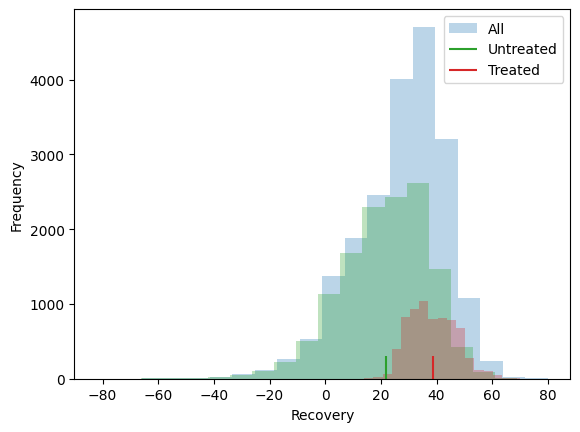

In [7]:
prior = smf.ols(f"{Y} ~ {T}", data=data).fit()
print(prior.summary().tables[1])

plt.hist(data[Y], bins=20, alpha=0.3, label="All")
plt.hist(data.query(f"{T}==0")[Y], bins=20, alpha=0.3, color="C2")
plt.hist(data.query(f"{T}==1")[Y], bins=20, alpha=0.3, color="C3")

plt.vlines(prior.params.Intercept, 0, 300, label="Untreated", color="C2")
plt.vlines(prior.params.Intercept+prior.params[T], 0, 300, label="Treated", color="C3")

plt.ylabel("Frequency")
plt.xlabel("Recovery")
plt.legend();
plt.show()

## Causal Inference using Matching Algorithm

### Idea: Matching each treated unit with a similar untreated unit
1. Finding an untreated twin for every treated unit.
2. By making such comparisons, treated and untreated become again comparable.

### Q: Similiarity in terms what?
We need to define a metric to measure simliarity.
For now, we will use Euclidean distance for simplicity.

(Make sure to normalize your data, e.g., zero-mean one-std , or whitening).

In [8]:
def run_matching(data):

    # Normalize Data
    data = data.assign(**{f: (data[f] - data[f].mean())/data[f].std() for f in X})
    treated = data.query(f"{T}==1")
    untreated = data.query(f"{T}==0")

    # KNN algorithm to find nearest neighbours model
    mt0 = KNeighborsRegressor(n_neighbors=1).fit(untreated[X], untreated[Y])
    mt1 = KNeighborsRegressor(n_neighbors=1).fit(treated[X], treated[Y])


    # Get the nearest neighbours
    mt0_neighbours = mt0.kneighbors(treated[X],n_neighbors=1)
    mt1_neighbours = mt1.kneighbors(untreated[X],n_neighbors=1)

    predicted = pd.concat([
        # find matches for the treated looking at the untreated knn model
        treated.assign(counterfactual_outcome=mt0.predict(treated[X]), \
                        matching_dist=mt0_neighbours[0].flatten()),

        # find matches for the untreated looking at the treated knn model
        untreated.assign(counterfactual_outcome=mt1.predict(untreated[X]), \
                            matching_dist=mt1_neighbours[0].flatten())
    ])

    ## Going to filter out the ones that don't qualify as pairs
    mt1_neighbours_threshold = mt1_neighbours[0].flatten().mean()
    mt0_neighbours_threshold = mt0_neighbours[0].flatten().mean()
    threshold = mt1_neighbours_threshold #(mt1_neighbours_threshold+mt0_neighbours_threshold)
    predicted_filtered = predicted#[predicted.matching_dist < threshold]

    final_table = predicted_filtered[[T,Y,"counterfactual_outcome"]]

    print('Y1')
    print(np.mean(final_table[Y]*final_table[T]+(1-final_table[T])*final_table["counterfactual_outcome"]))
    print('Y0')
    print(np.mean(final_table[Y]*(1-final_table[T])+(final_table[T])*final_table["counterfactual_outcome"]))
    print(final_table)

    ATE = np.mean((2*final_table[T] - 1)*(final_table[Y] - final_table["counterfactual_outcome"]))
    print(f"ATE: {ATE}")


run_matching(data.copy())

Y1
29.1482
Y0
30.1436
       medication  recovery  counterfactual_outcome
0               1        31                    39.0
1               1        49                    52.0
7               1        38                    46.0
10              1        34                    45.0
16              1        30                    39.0
...           ...       ...                     ...
19994           0        48                    44.0
19996           0         5                    21.0
19997           0        37                    31.0
19998           0         6                    20.0
19999           0        44                    34.0

[20000 rows x 3 columns]
ATE: -0.9954


## Causal Inference using Inverse Probaiblity Weighting


\begin{align}
  \mathbb{E}[Y[1]] &= \mathbb{E}\left[\frac{YA}{e(x)}\Bigg|X\right]\\
  \mathbb{E}[Y[0]] &= \mathbb{E}\left[\frac{Y(1-A)}{1-e(x)}\Bigg|X\right]
\end{align}
where $e(x) = P(A=1|X)$ is the propensity score.


#### Let's fit a logistic r egression on the dataset
* $Y = \sigma(WX+b)$ where $\sigma$ is the sigmoid function, W and b are. parameters and bias.


In [9]:
data = pd.read_csv("medicine_impact_recovery.csv")

def train_propensity_score(data):
    X = data.columns.drop([T, Y])
    data = data.assign(**{f: (data[f] - data[f].mean())/data[f].std() for f in X})

    ps_model = LogisticRegression(C=1e6, solver='lbfgs', max_iter=20).fit(data[X], data[T])
    data_ps = data.assign(propensity_score=ps_model.predict_proba(data[X])[:, 1])
    print(data_ps[[T, Y, P]].head())
    return data_ps

data_ps = train_propensity_score(data.copy())

   medication  recovery  propensity_score
0           1        31      9.987947e-01
1           1        49      9.999845e-01
2           0        38      6.652871e-02
3           0        35      3.328392e-04
4           0        15      1.441361e-07


## Visualization of estimated $p(A|X)$
* Check how much overlap we have.

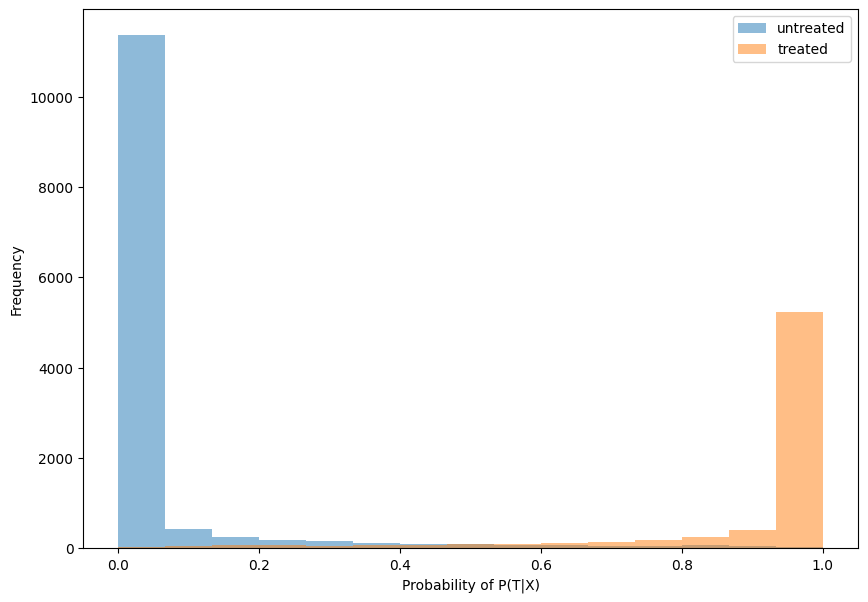

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))

axs.hist(data_ps[data_ps[T]==0].propensity_score, bins=15, range=[0,1], label='untreated', alpha=0.5)
axs.hist(data_ps[data_ps[T]==1].propensity_score, bins=15, range=[0,1], label='treated', alpha=0.5)
axs.legend()
axs.set_xlabel("Probability of P(T|X)")
axs.set_ylabel("Frequency")
plt.show()

## Observing Propensity Score
* Use the propensity score to find evidence of confounding

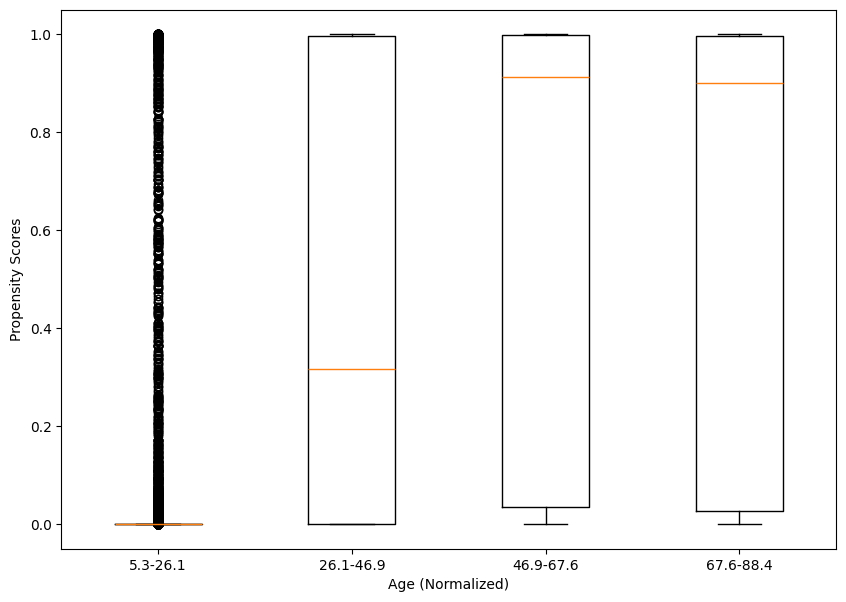

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(10, 7))
vmin, vmax = data_ps.age.min(), data_ps.age.max()
age_mean = data["age"].mean()
age_std = data["age"].std()

bins = 4
step = (vmax-vmin) / bins
labels =[]
histogram = []

for bin_i in range(0,bins):
    recovery_i =  vmin + bin_i*step
    recovery_ip1 = vmin + (bin_i+1)*step
    histogram.append(data_ps[data_ps.age.between(recovery_i, recovery_ip1)].propensity_score.values)
    labels.append(f"{recovery_i*age_std+age_mean:.1f}-{recovery_ip1*age_std+age_mean:.1f}")

axs.boxplot(histogram, labels=labels)
axs.set_xlabel('Age (Normalized)')
axs.set_ylabel('Propensity Scores')
plt.show()

## Apply Propensity Score

\begin{align}
  \mathbb{E}[Y[1]] &= \mathbb{E}\left[\frac{YT}{e(x)}\Bigg|X\right]\\
  \mathbb{E}[Y[0]] &= \mathbb{E}\left[\frac{Y(1-T)}{1-e(x)}\Bigg|X\right]\\
  ATE &= \mathbb{E}\left[Y \frac{T-e(x)}{e(x)(1-e(x))}\Bigg|X\right]
\end{align}

In [15]:

def run_IPW(data):
    ## Prep
    X = data.columns.drop([T, Y])
    data = data.assign(**{f: (data[f] - data[f].mean())/data[f].std() for f in X})
    data_ps = train_propensity_score(data)
    print(data_ps[[T, Y, P]].head())

    ## Get Inverse Probability Weights
    weight_t = 1/data_ps.query(f"{T}==1")[P]
    weight_nt = 1/(1-data_ps.query(f"{T}==0")[P])
    print("Original Sample Size", data.shape[0])
    print("Treated Population Sample Size", sum(weight_t))
    print("Untreated Population Sample Size", sum(weight_nt))

    ## Apply to outcomes.
    weight = ((data[T]-data_ps[P]) / (data_ps[P]*(1-data_ps[P])))
    y1 = sum(data_ps.query(f"{T}==1")[Y]*weight_t) / len(data)
    y0 = sum(data_ps.query(f"{T}==0")[Y]*weight_nt) / len(data)
    ate = np.mean(weight * data_ps[Y])

    print("Y1:", y1)
    print("Y0:", y0)
    print("ATE", ate)

    # # 1/n sum_i^n y_i I[a_i=a]
    # mean([y_1, y_3, y_5])
    # mean([y_1, 0, y_3, 0, y_5])

run_IPW(data.copy())

   medication  recovery  propensity_score
0           1        31      9.987947e-01
1           1        49      9.999845e-01
2           0        38      6.652871e-02
3           0        35      3.328392e-04
4           0        15      1.441361e-07
   medication  recovery  propensity_score
0           1        31      9.987947e-01
1           1        49      9.999845e-01
2           0        38      6.652871e-02
3           0        35      3.328392e-04
4           0        15      1.441361e-07
Original Sample Size 20000
Treated Population Sample Size 10051.06864745325
Untreated Population Sample Size 15977.97376979346
Y1: 17.957327006587178
Y0: 20.593759970949176
ATE -2.6364329643619526


In Summary

|                   |  Y0    | Y1    | ATE  |   |
|---|---|---|---|---|
|  Biased Estimator |  21.68 | 38.57 | 16.9  |   |
|  Matching |  31.6 |  37.68 |   -6.08 | |
|  IPW  |  17.96  | 20.59  |  -2.64 | |